<a href="https://colab.research.google.com/github/Bibitpamungkas/TugasBesar_MachineLearning/blob/kelompok/Final_Code_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tulis Program Anda Disini!
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Imports untuk membangun CNN
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/tmp/"

In [ ]:
# jika anda ingin menggunakan kaggle API untuk mengunduh dataset gunakan
# kode berikut untuk membantu anda membuat config kaggle.json
# pastikan anda mendaftar akun kaggle terlebih dahulu
# kemudian menuju halaman my account dan buat token API anda

api_token = {"username":"bibitpamungkas","key":"0b4a500fd9a858ee152de296398002ab"}
import json
import zipfile
import os
with open('/tmp/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /tmp/kaggle.json

In [ ]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

 99% 1.73G/1.74G [00:41<00:00, 42.2MB/s]
100% 1.74G/1.74G [00:41<00:00, 45.1MB/s]


In [ ]:
# Ekstrak dataset

import os
import zipfile

os.makedirs('/tmp/chest-xray-pneumoniacovid19tuberculosis')

local_zip = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest-xray-pneumoniacovid19tuberculosis')
zip_ref.close()

In [ ]:
import os
base_dir = '/tmp/chest-xray-pneumoniacovid19tuberculosis'
train = os.path.join(base_dir,'train')
validation = os.path.join(base_dir,'val')
test = os.path.join(base_dir,'test')

c19_tr = os.path.join(train,'COVID19')
c19_va = os.path.join(validation,'COVID19')
c19_ts = os.path.join(test,'COVID19')

nr_tr = os.path.join(train,'NORMAL')
nr_va = os.path.join(validation,'NORMAL')
nr_ts = os.path.join(test,'NORMAL')

pn_tr = os.path.join(train,'PNEUMONIA')
pn_va = os.path.join(validation,'PNEUMONIA')
pn_ts = os.path.join(test,'PNEUMONIA')

tb_tr = os.path.join(train,'TURBERCULOSIS')
tb_va = os.path.join(validation,'TURBERCULOSIS')
tb_ts = os.path.join(test,'TURBERCULOSIS')

#file training dan validation
file_train_c19 = os.listdir(c19_tr)
file_validation_c19 = os.listdir(c19_va)
file_test_c19 = os.listdir(c19_ts)
file_train_nr = os.listdir(nr_tr)
file_validation_nr = os.listdir(nr_va)
file_test_nr = os.listdir(nr_ts)
file_train_pn = os.listdir(pn_tr)
file_validation_pn = os.listdir(pn_va)
file_test_pn = os.listdir(pn_ts)
file_train_tb = os.listdir(tb_tr)
file_validation_tb = os.listdir(tb_va)
file_test_tb = os.listdir(tb_ts)

#Print jumlah data training dan validation
print("Data COVID19 Train : " + str(len(file_train_c19)))
print("Data COVID19 Validation : " + str(len(file_validation_c19)))
print("Data COVID19 Test : " + str(len(file_test_c19)))
print("Data NORMAL Train : " + str(len(file_train_nr)))
print("Data NORMAL Validation : " + str(len(file_validation_nr)))
print("Data NORMAL Test : " + str(len(file_test_nr)))
print("Data PNEUMONIA Train : " + str(len(file_train_pn)))
print("Data PNEUMONIA Validation : " + str(len(file_validation_pn)))
print("Data PNEUMONIA Test : " + str(len(file_test_pn)))
print("Data TURBERCULOSIS Train : " + str(len(file_train_tb)))
print("Data TURBERCULOSIS Validation : " + str(len(file_validation_tb)))
print("Data TURBERCULOSIS Test : " + str(len(file_test_tb)))

Data COVID19 Train : 460
Data COVID19 Validation : 10
Data COVID19 Test : 106
Data NORMAL Train : 1341
Data NORMAL Validation : 8
Data NORMAL Test : 234
Data PNEUMONIA Train : 3875
Data PNEUMONIA Validation : 8
Data PNEUMONIA Test : 390
Data TURBERCULOSIS Train : 650
Data TURBERCULOSIS Validation : 12
Data TURBERCULOSIS Test : 41


In [ ]:
# TULIS KODE ANDA DISINI
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=32

augmen_gen = ImageDataGenerator(rescale=1/255,rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, 
                        zoom_range=0.8, horizontal_flip=True,
                        fill_mode="nearest")
#melakukan class mode= metode pemilihan clasifikasi, taret size= dimensi citra, batch size= banyak citra yg dimasukkan setiap step, shuffle= acak data tida sesusai alfabetik
train_aug = augmen_gen.flow_from_directory(
    '/tmp/chest-xray-pneumoniacovid19tuberculosis/train',
    class_mode = 'categorical',
    shuffle=True,
    target_size = (50,50),
    batch_size=batch_size,
    color_mode ='rgb'
)

test_aug = augmen_gen.flow_from_directory(
    '/tmp/chest-xray-pneumoniacovid19tuberculosis/test',
    class_mode = 'categorical',
    shuffle=False,
    target_size = (50,50),
    batch_size=batch_size,
    color_mode ='rgb',
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [ ]:
# TULIS KODE ANDA DISINI
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# DEFINISIKAN MODEL ANDA DISINI

#Feature Selection
model = Sequential()

model.add(InputLayer(input_shape=[50,50,3]))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())

#Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 256)       

In [ ]:
# tell the model what cost and optimization method to use
from tensorflow.keras.optimizers import Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy']
)

In [ ]:
# Mencocokan model
r = model.fit_generator(
  train_aug,
  validation_data=test_aug,
  epochs=50,
  steps_per_epoch=len(train_aug), 
  validation_steps=len(test_aug)
)       

Epoch 1/50
198/198 [==============================] - 104s 524ms/step - loss: 0.8452 - accuracy: 0.6696 - val_loss: 1.5024 - val_accuracy: 0.0895
Epoch 2/50
198/198 [==============================] - 96s 485ms/step - loss: 0.6898 - accuracy: 0.7365 - val_loss: 0.7574 - val_accuracy: 0.7069
Epoch 3/50
198/198 [==============================] - 92s 467ms/step - loss: 0.6311 - accuracy: 0.7610 - val_loss: 1.0275 - val_accuracy: 0.6135
Epoch 4/50
198/198 [==============================] - 93s 471ms/step - loss: 0.5676 - accuracy: 0.7787 - val_loss: 0.9469 - val_accuracy: 0.6291
Epoch 5/50
198/198 [==============================] - 95s 482ms/step - loss: 0.5563 - accuracy: 0.7842 - val_loss: 0.7417 - val_accuracy: 0.7082
Epoch 6/50
198/198 [==============================] - 94s 470ms/step - loss: 0.5248 - accuracy: 0.7980 - val_loss: 1.1686 - val_accuracy: 0.6524
Epoch 7/50
198/198 [==============================] - 94s 477ms/step - loss: 0.4731 - accuracy: 0.8245 - val_loss: 1.0340 - val_a

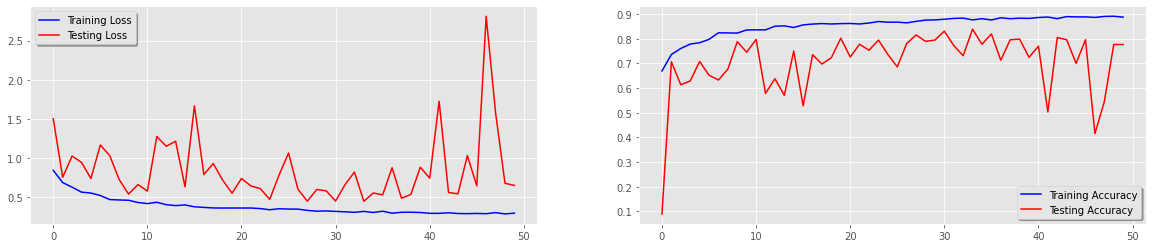

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)  

ax[0].plot(r.history['loss'], color='b', label="Training Loss")
ax[0].plot(r.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(r.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(r.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True) 

In [ ]:
from sklearn.metrics import classification_report
ypred = model.predict(test_aug)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_aug.classes, prediction))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       106
           1       0.90      0.50      0.65       234
           2       0.77      0.96      0.86       390
           3       0.61      0.95      0.74        41

    accuracy                           0.79       771
   macro avg       0.79      0.78      0.76       771
weighted avg       0.81      0.79      0.78       771



In [ ]:
import tensorflow as tf
# (to generate a SavedModel) 

from google.colab import files

model.save('model11.h5')
files.download('model11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
# Feature Extraction Layer
model1 = Sequential()

model1.add(InputLayer(input_shape=[50,50,3]))
model1.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))
model1.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=2, padding='same'))
model1.add(Flatten())
# Fully Connected Layer
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
# Print model summary
print(model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 25, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 64)        

In [ ]:
# tell the model what cost and optimization method to use
from tensorflow.keras.optimizers import Adam
model1.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy']
)

In [ ]:
H1 = model1.fit_generator(
  train_aug,
  validation_data=test_aug,
  epochs=50,
  steps_per_epoch=len(train_aug),
  validation_steps=len(test_aug)
)      

Epoch 1/50
198/198 [==============================] - 99s 494ms/step - loss: 0.8662 - accuracy: 0.6717 - val_loss: 0.8297 - val_accuracy: 0.6641
Epoch 2/50
198/198 [==============================] - 93s 470ms/step - loss: 0.6917 - accuracy: 0.7370 - val_loss: 0.7564 - val_accuracy: 0.7160
Epoch 3/50
198/198 [==============================] - 93s 471ms/step - loss: 0.6147 - accuracy: 0.7667 - val_loss: 0.7707 - val_accuracy: 0.6991
Epoch 4/50
198/198 [==============================] - 94s 476ms/step - loss: 0.5643 - accuracy: 0.7842 - val_loss: 0.6868 - val_accuracy: 0.7121
Epoch 5/50
198/198 [==============================] - 94s 473ms/step - loss: 0.5387 - accuracy: 0.7947 - val_loss: 0.8085 - val_accuracy: 0.6835
Epoch 6/50
198/198 [==============================] - 94s 473ms/step - loss: 0.5043 - accuracy: 0.8046 - val_loss: 0.8284 - val_accuracy: 0.6680
Epoch 7/50
198/198 [==============================] - 94s 473ms/step - loss: 0.4851 - accuracy: 0.8149 - val_loss: 0.6344 - val_ac

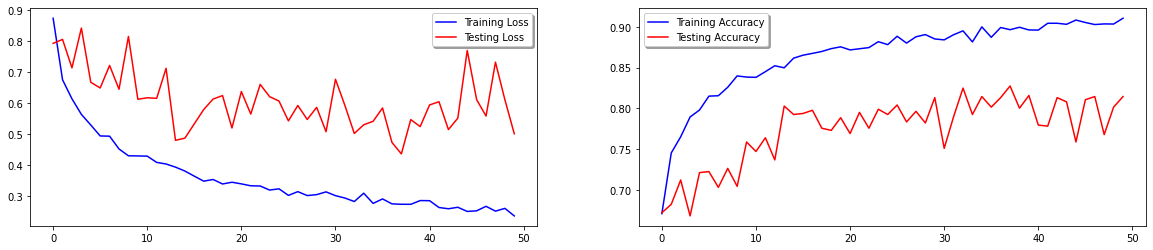

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)

ax[0].plot(H1.history['loss'], color='b', label="Training Loss")
ax[0].plot(H1.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(H1.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(H1.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True) 

In [ ]:
from sklearn.metrics import classification_report
ypred = model1.predict(test_aug)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_aug.classes, prediction))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       106
           1       0.88      0.59      0.70       234
           2       0.82      0.95      0.88       390
           3       0.71      0.95      0.81        41

    accuracy                           0.82       771
   macro avg       0.81      0.83      0.80       771
weighted avg       0.83      0.82      0.81       771



In [ ]:
# (to generate a SavedModel) 
model1.save('model12.h5')
files.download('model12.h5')

from google.colab import files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# TULIS KODE ANDA DISINI
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# DEFINISIKAN MODEL ANDA DISINI

#Feature Selection
model2 = Sequential()

model2.add(InputLayer(input_shape=[50,50,3]))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Dropout(0.7))
model2.add(BatchNormalization())
model2.add(Flatten())

#Fully Connected Layer
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
print(model2.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 128)       

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam

model2.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
H2 = model2.fit(train_aug,steps_per_epoch=10, epochs=50, validation_data=test_aug, validation_steps=10, verbose=2)

Epoch 1/50
10/10 - 15s - loss: 1.2952 - acc: 0.4656 - val_loss: 1.3897 - val_acc: 0.0000e+00 - 15s/epoch - 2s/step
Epoch 2/50
10/10 - 14s - loss: 1.2701 - acc: 0.5469 - val_loss: 1.3290 - val_acc: 0.6625 - 14s/epoch - 1s/step
Epoch 3/50
10/10 - 14s - loss: 1.0510 - acc: 0.6031 - val_loss: 1.3190 - val_acc: 0.6625 - 14s/epoch - 1s/step
Epoch 4/50
10/10 - 14s - loss: 1.0546 - acc: 0.6000 - val_loss: 1.3254 - val_acc: 0.5562 - 14s/epoch - 1s/step
Epoch 5/50
10/10 - 12s - loss: 1.1328 - acc: 0.5469 - val_loss: 1.3216 - val_acc: 0.5531 - 12s/epoch - 1s/step
Epoch 6/50
10/10 - 14s - loss: 1.0599 - acc: 0.6125 - val_loss: 1.3076 - val_acc: 0.6125 - 14s/epoch - 1s/step
Epoch 7/50
10/10 - 14s - loss: 1.0194 - acc: 0.6062 - val_loss: 1.3005 - val_acc: 0.6438 - 14s/epoch - 1s/step
Epoch 8/50
10/10 - 15s - loss: 1.0824 - acc: 0.5625 - val_loss: 1.2933 - val_acc: 0.6125 - 15s/epoch - 2s/step
Epoch 9/50
10/10 - 14s - loss: 1.1131 - acc: 0.5719 - val_loss: 1.2891 - val_acc: 0.5938 - 14s/epoch - 1s/st

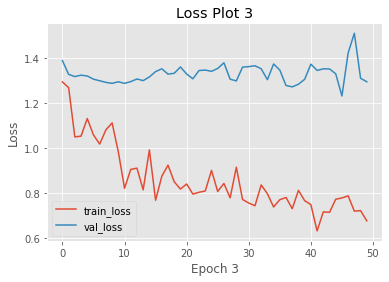

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H2.history["val_loss"], label="val_loss")
plt.title("Loss Plot 3")
plt.xlabel("Epoch 3")
plt.ylabel("Loss")
plt.legend()
plt.show()

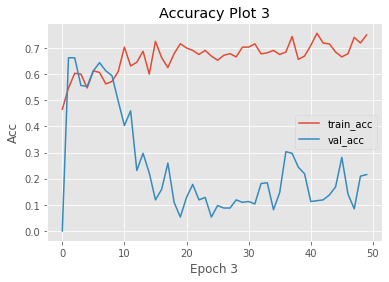

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H2.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H2.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot 3")
plt.xlabel("Epoch 3")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
ypred = model2.predict(test_aug)
prediction3 = np.argmax(ypred, axis=1)
print(classification_report(test_aug.classes, prediction3))

              precision    recall  f1-score   support

           0       0.68      0.37      0.48       106
           1       0.84      0.16      0.27       234
           2       0.60      0.97      0.74       390
           3       0.71      0.71      0.71        41

    accuracy                           0.63       771
   macro avg       0.71      0.55      0.55       771
weighted avg       0.69      0.63      0.56       771



In [ ]:
import tensorflow as tf
model2.save('model3.h5')

from google.colab import files
files.download('model3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>